# Mount Google Drive

In [ ]:
import os
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
if not os.path.exists('/content/tools'):
    os.mkdir(f"/content/tools")
!cp /content/drive/MyDrive/CMU/Spring2022/11785-Intro-to-Deep-Learning/tools/* /content/tools
if not os.path.exists('/content/networks'):
    os.mkdir(f"/content/networks")
!cp /content/drive/MyDrive/CMU/Spring2022/11785-Intro-to-Deep-Learning/hw4/networks/* /content/networks

In [ ]:
from tools.model_saver import StoredModel, ModelSaver
from tools.load_model import load_model
from tools.execute_shell import execute_shell
from tools.kaggle import setup_kaggle
from networks.LAS_variant_m1 import Encoder, Attention, Decoder, Seq2Seq, create_dictionaries, transform_index_to_letter
from networks.locked_dropout import LockedDropout

# Libraries and Initial Processing

In [ ]:
!pip install python-levenshtein

In [ ]:
import json
import os
import sys
import pandas as pd
import numpy as np
import Levenshtein as lev
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
import datetime
from torch.utils import data
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from tqdm import tqdm

cuda = torch.cuda.is_available()

print(cuda, sys.version)

DEVICE = torch.device("cuda" if cuda else "cpu")
num_workers = 2 if cuda else 0
print("Cuda = "+str(cuda)+" with num_workers = "+str(num_workers))
print(torch.cuda.get_device_name(0))
np.random.seed(11785)
torch.manual_seed(11785)

# The labels of the dataset contain letters in LETTER_LIST.
# You should use this to convert the letters to the corresponding indices
# and train your model with numerical labels.
LETTER_LIST = ['<sos>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', \
         'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', "'", ' ', '<eos>']

True 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
Cuda = True with num_workers = 2
A100-SXM4-40GB


# Parameter setting

In [ ]:
model_id = 'model_5_r1'
checkpoints = '/content/model_checkpoints'
if not os.path.exists(checkpoints):
    os.mkdir(checkpoints)
drive_checkpoint = "/content/drive/MyDrive/CMU/Spring2022/11785-Intro-to-Deep-Learning/hw4/model_checkpoints"
if not os.path.exists(drive_checkpoint):
    os.mkdir(drive_checkpoint)
if not os.path.exists(f"{drive_checkpoint}/{model_id}"):
    os.mkdir(f"{drive_checkpoint}/{model_id}")

lr = 0.001
batch_size = 64
# batch_size = 2
epochs = 25
structure = {
    'encoder_hidden_dim': 512, 
    'decoder_hidden_dim': 512, 
    'embed_dim': 256, 
    'key_value_size': 128, 
    'teacher_forcing_rate': 0.9, # initial tf rate
    'tf_reduce_by': 0.1,
    'learning_rate_patience': 10, # start to schedule after n epochs (not used)
    'lev_dist_patience': 20, # start to schedule when lev dist less than this
    'gumbel': False,
    'encoder_dropout': 0.3,
    'decoder_dropout': None,
}
resume_from_prev = True
if resume_from_prev:
    prev_model_id = "model_5"
    specific_epoch = 24
    change_dropout_flag = True

In [ ]:
# Create the letter2index and index2letter dictionary
letter2index, index2letter = create_dictionaries(LETTER_LIST)

# Kaggle (TODO)

In [ ]:
setup_kaggle()

Running Command: 'pip install --upgrade --force-reinstall --no-deps kaggle'


Elapsed Time (in second):   0%|          | 1/300 [00:01<05:03,  1.01s/it]


Completed!!!

Running Command: 'mkdir /root/.kaggle'


Elapsed Time (in second):   0%|          | 1/300 [00:01<05:03,  1.01s/it]


Completed!!!

Running Command: 'chmod 600 /root/.kaggle/kaggle.json'


Elapsed Time (in second):   0%|          | 1/300 [00:01<05:03,  1.01s/it]

Completed!!!



In [ ]:
import subprocess

commands = ["kaggle competitions download -c 11-785-s22-hw4p2",
            "unzip -q 11-785-s22-hw4p2.zip"]

if not os.path.exists('/content/11-785-s22-hw4p2.zip'):
    execute_shell(commands[0])
    execute_shell(commands[1])

print(subprocess.run("ls", universal_newlines=True, stdout=subprocess.PIPE).stdout)

11-785-s22-hw4p2.zip
drive
hw4p2_simple
hw4p2_student_data
model_checkpoints
networks
sample_data
submission.csv
tools



# Dataset and Dataloading (TODO)

You will need to implement the Dataset class by your own. You can implement it similar to HW3P2. However, you are welcomed to do it your own way if it is more comfortable or efficient.

Note that you need to use LETTER_LIST to convert the transcript into numerical labels for the model.


Example of raw transcript:

    ['<sos>', 'N', 'O', 'R', 'T', 'H', 'A', 'N', 'G', 'E', 'R', ' ','A', 'B', 'B', 'E', 'Y', '<eos>']

Example of converted transcript ready to process for the model:

    [0, 14, 15, 18, 20, 8, 1, 14, 7, 5, 18, 28, 1, 2, 2, 5, 25, 29]


In [ ]:
class LibriSamples(torch.utils.data.Dataset):

    def __init__(self, data_path, partition= "train", test=False, noise_prob=0.3, transforms=None):
        self.test = test
        self.transforms = transforms

        if not test:
            self.X_dir = f"{data_path}/{partition}/mfcc"
            self.Y_dir = f"{data_path}/{partition}/transcript"

            self.X_files = os.listdir(self.X_dir)
            self.Y_files = os.listdir(self.Y_dir)
            self.noise_prob = noise_prob
        else:
            test_order_list = np.loadtxt(f"{data_path}/test/test_order.csv", dtype=str)[1:]
            self.X_dir = f"{data_path}/test/mfcc"
            self.X_files = test_order_list
        
        self.letter_list = LETTER_LIST

        if not test:
            assert(len(self.X_files) == len(self.Y_files))

        self.length = len(self.X_files)

    def __len__(self):
        return self.length

    def __getitem__(self, ind):
        X_path = f"{self.X_dir}/{self.X_files[ind]}"
        X = np.load(X_path)
        X = (X - X.mean(axis=0)) / X.std(axis=0)
        X = torch.from_numpy(X)

        if self.test:
            return X
        else:
            if not self.transforms is None:
                X = self.transforms(X)
            Y_path = f"{self.Y_dir}/{self.Y_files[ind]}"
            Y = [self.letter_list.index(yy) for yy in np.load(Y_path)]

            Yy = torch.Tensor(Y).long() # Convert sequence of  phonemes into sequence of Long tensors

            return X, Yy

    def collate_fn(self, batch):
        if not self.test:
            batch_x = [x for x,y in batch]
            batch_y = [y[1:] for x,y in batch] # [1:] removing <sos>
            # batch_y = [y for x,y in batch]
        else:
            batch_x = batch

        batch_x_pad = pad_sequence(batch_x, batch_first=True) # pad the sequence with pad_sequence (already imported)
        lengths_x = [len(x) for x in batch_x] # Get original lengths of the sequence before padding

        if not self.test:
            batch_y_pad = pad_sequence(batch_y, batch_first=True) # pad the sequence with pad_sequence (already imported)
            lengths_y = [len(y) for y in batch_y] # Get original lengths of the sequence before padding

            return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)
        
        else:
            return batch_x_pad, torch.tensor(lengths_x)

    # def collate_fn_train(batch):

    #     batch_x = [x for x,y in batch]
    #     batch_y = [y[1:] for x,y in batch] # [1:] removing <sos>

    #     batch_x_pad = pad_sequence(batch_x, batch_first=True) # TODO: pad the sequence with pad_sequence (already imported)
    #     lengths_x = [len(x) for x in batch_x] # TODO: Get original lengths of the sequence before padding

    #     batch_y_pad = pad_sequence(batch_y, batch_first=True) # TODO: pad the sequence with pad_sequence (already imported)
    #     lengths_y = [len(y) for y in batch_y]

    #     return batch_x_pad, batch_y_pad, torch.tensor(lengths_x), torch.tensor(lengths_y)

    # def collate_fn_test(batch):

    #     batch_x = batch

    #     batch_x_pad = pad_sequence(batch_x, batch_first=True) # TODO: pad the sequence with pad_sequence (already imported)
    #     lengths_x = [len(x) for x in batch_x] # TODO: Get original lengths of the sequence before padding

    #     return batch_x_pad, torch.tensor(lengths_x)

In [ ]:
root = '/content/hw4p2_student_data/hw4p2_student_data'

train_data = LibriSamples(root, partition='train')# TODO
val_data = LibriSamples(root, partition='dev')# TODO
test_data = LibriSamples(root, test=True)# TODO

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=train_data.collate_fn, num_workers=num_workers, drop_last=True, pin_memory=True)

val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True, collate_fn=train_data.collate_fn, num_workers=num_workers, drop_last=True, pin_memory=True)

test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=test_data.collate_fn, num_workers=1, pin_memory=True)


print("Batch size: ", batch_size)
print("Train dataset samples = {}, batches = {}".format(train_data.__len__(), len(train_loader)))
print("Val dataset samples = {}, batches = {}".format(val_data.__len__(), len(val_loader)))
print("Test dataset samples = {}, batches = {}".format(test_data.__len__(), len(test_loader)))

Batch size:  64
Train dataset samples = 28539, batches = 445
Val dataset samples = 2703, batches = 42
Test dataset samples = 2620, batches = 41


In [ ]:
# test code for checking shapes
for data in val_loader:
    x, y, lx, ly = data
    print(x.shape, y.shape, lx.shape, len(ly))
    print(y[0]) # desired 
    break

torch.Size([64, 1634, 13]) torch.Size([64, 291]) torch.Size([64]) 64
tensor([13,  1, 18, 20,  8,  1, 28, 18,  5, 13,  5, 13,  2,  5, 18,  5,  4, 28,
        20,  8,  5, 28,  3, 12, 15, 19,  5,  4, 28,  4, 15, 15, 18, 28, 15, 14,
        28, 20,  8,  5, 28,  6,  9, 18, 19, 20, 28, 19, 21, 18, 22,  5, 25, 28,
        20,  8,  5, 25, 28,  8,  1,  4, 14, 27, 20, 28,  1, 20, 20,  5, 13, 16,
        20,  5,  4, 28, 15, 16,  5, 14,  9, 14,  7, 28,  9, 20, 29,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

# Model (TODO)

In [ ]:
encoder = Encoder(13, 256)# fill this out
# Try out your encoder on a tiny input before moving to the next step...
x = [torch.randn(100, 13), torch.randn(64, 13), torch.randn(80, 13)]
lx = torch.tensor([len(xx) for xx in x])
x = pad_sequence(x, batch_first=True)
key, value, out_lengths = encoder(x, lx)
print(key.shape)
print(value.shape)
print(out_lengths)

torch.Size([3, 12, 128])
torch.Size([3, 12, 128])
tensor([12,  8, 10])


In [ ]:
query = torch.randn(3, key.shape[2])
mask = torch.arange(key.shape[1]).unsqueeze(0) >= lx.unsqueeze(1)
att = Attention()
attention, context = att(query, key, value, mask)

In [ ]:
print(value.mean(axis=1).shape)

torch.Size([3, 128])


In [ ]:
B, key_seq_max_len, key_value_size = key.shape
prediction = torch.full((B, 1), fill_value=0)

prediction.argmax(dim=-1)

tensor([0, 0, 0])

In [ ]:
nn.Embedding(30, 256, padding_idx=letter2index['<eos>'])(torch.full((B, ), fill_value=letter2index['<sos>'])).shape

torch.Size([3, 256])

In [ ]:
# dummy_model = Seq2Seq(input_dim=13, 
#                 vocab_size=len(LETTER_LIST), 
#                 encoder_hidden_dim=structure['encoder_hidden_dim'], 
#                 decoder_hidden_dim=structure['decoder_hidden_dim'], 
#                 embed_dim=structure['embed_dim'], 
#                 key_value_size=structure['key_value_size'])
# # test code for checking shapes
# print(dummy_model)

In [ ]:
# for data in val_loader:
#     x, y, lx, ly = data
#     predictions, attentions = dummy_model(x, lx, y=y, mode='train', teacher_forcing_rate=1.0)
#     break

In [ ]:
# Debug
# DEVICE = 'cpu'

In [ ]:
model = Seq2Seq(input_dim=13, 
                vocab_size=len(LETTER_LIST), 
                encoder_hidden_dim=structure['encoder_hidden_dim'], 
                decoder_hidden_dim=structure['decoder_hidden_dim'], 
                embed_dim=structure['embed_dim'], 
                key_value_size=structure['key_value_size'],
                gumbel=structure['gumbel'],
                encoder_dropout=structure['encoder_dropout'],
                decoder_dropout=structure['decoder_dropout'])
# model = Seq2Seq(input_dim=13, 
#                 vocab_size=len(LETTER_LIST), 
#                 encoder_hidden_dim=structure['encoder_hidden_dim'], 
#                 decoder_hidden_dim=structure['decoder_hidden_dim'], 
#                 embed_dim=structure['embed_dim'],)

model = model.to(DEVICE)
print(model)

Seq2Seq(
  (encoder): Encoder(
    (lstm): LSTM(13, 512, batch_first=True, bidirectional=True)
    (pBLSTMs): Sequential(
      (0): LockedDropout()
      (1): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
      )
      (2): LockedDropout()
      (3): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
      )
      (4): LockedDropout()
      (5): pBLSTM(
        (blstm): LSTM(2048, 512, batch_first=True, bidirectional=True)
      )
    )
    (key_network): Linear(in_features=1024, out_features=128, bias=True)
    (value_network): Linear(in_features=1024, out_features=128, bias=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(30, 256, padding_idx=29)
    (lstm1): LSTMCell(384, 512)
    (lstm2): LSTMCell(512, 128)
    (attention): Attention()
    (character_prob): Linear(in_features=256, out_features=30, bias=True)
  )
)


In [ ]:
class TF_Scheduler(object):
    def __init__(self, init_tf_rate=1.0, limit=0.7, patience=3, mode='min', reduce_by=0.005, threshold=1e-4, force_drop=5):
        self.tf_rate = init_tf_rate
        self.limit = limit
        self.patience = patience
        self.mode = mode
        self.reduce_by = reduce_by
        self.threshold = threshold
        self.force_drop = force_drop
        self.num_force_epochs = 0
        self.best = None
        self.num_bad_epochs = 0

    def step(self, metric):
        if self.best is None:
            self.best = metric
        current = float(metric)
        self.num_force_epochs += 1

        if self.is_better(current, self.best):
            self.best = current
            self.num_bad_epochs = 0
        else:
            self.num_bad_epochs += 1
        
        if self.num_bad_epochs >= self.patience:
            self.num_bad_epochs = 0
            self.num_force_epochs = 0
            return self._reduce()
        elif self.num_force_epochs >= self.force_drop:
            self.num_bad_epochs = 0
            self.num_force_epochs = 0
            return self._reduce()
        else:
            return self.tf_rate

    def is_better(self, current, best):
        if self.mode == 'min':
            rel_epsilon = 1. - self.threshold
            return current < best * rel_epsilon
        else:
            return NotImplemented
        
    def _reduce(self):
        old_value = self.tf_rate
        self.tf_rate = max(self.limit, self.tf_rate - self.reduce_by)
        if old_value > self.tf_rate:
            print(f"***\nReduced Teacher Forcing Rate from {old_value} to {self.tf_rate}\n***")
        return self.tf_rate

# Training

In [ ]:
def change_dropout(model, p, dropout_module: nn.Module):
    for m in model.modules():
        if isinstance(m, dropout_module):
            m.p = p

In [ ]:
if resume_from_prev:
    epoch_start, model, optimizer, scheduler, criterion = load_model(model_id=prev_model_id, checkpoints=drive_checkpoint, device=DEVICE, specific_epoch=specific_epoch)
    epoch_start += 1
    model.cuda()
    # optimizer.param_groups[0]["lr"] = 0.0001
    teacher_forcing_rate = 0.6
    tf_scheduler = TF_Scheduler(init_tf_rate=0.6, limit=0.6, patience=3, reduce_by=0.05)
    start_tf_schedule = True
else:
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.75, patience=1, verbose=True, threshold=1e-2)
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    # Make sure you understand the implication of setting reduction = 'none'
    criterion = nn.CrossEntropyLoss(reduction='none')
    epoch_start = 0
    teacher_forcing_rate = structure['teacher_forcing_rate']
    tf_scheduler = TF_Scheduler(init_tf_rate=0.9, limit=0.6, patience=3, reduce_by=0.05)
    start_tf_schedule = False

resuming from last_checkpoint epoch_24


In [ ]:
# save the model
model_saver = ModelSaver(mode='min', model_id=model_id, checkpoints=checkpoints)

if not os.path.exists(f"{checkpoints}/{model_id}"):
    os.mkdir(f"{checkpoints}/{model_id}")
with open(f"{checkpoints}/{model_id}/model_spec.txt", mode="w") as f:
    f.write(json.dumps(structure) + "\n")
    f.write(str(model) + "\n")
    f.write(str(optimizer) + "\n")
    f.write(str(criterion) + "\n")
    f.write(str(scheduler) + "\n")
    #f.write(model_spec.replace("├─", "|-"))
    #f.write(model_spec)

In [ ]:
def save_log(log: str, checkpoints: str, model_id: str):
    with open(f"{checkpoints}/{model_id}/log.txt", mode='a') as f:
        f.write(f"{log}\n")

In [ ]:
def calc_lev_dist(predictions, targets):
    total_dist = 0.0
    batch_size = len(predictions)

    for pred, target in zip(predictions, targets):
        total_dist += lev.distance(pred, target)

    return total_dist / batch_size

In [ ]:
def train(model, train_loader, criterion, optimizer, teacher_forcing_rate, batch_bar):
    model.train()
    running_loss = 0.0
    running_perplexity = 0.0
    torch.cuda.empty_cache()
    
    # 0) Iterate through your data loader
    for i, (x, y, x_len, y_len) in enumerate(train_loader):
        optimizer.zero_grad()

        # 1) Send the inputs to the device
        x, x_len, y, y_len = x.to(DEVICE), x_len.to(DEVICE), y.to(DEVICE), y_len.to(DEVICE)
        # 2) Pass your inputs, and length of speech into the model.
        predictions, attentions = model(x, x_len, y=y, mode='train', teacher_forcing_rate=teacher_forcing_rate)
        
        # 3) Generate a mask based on target length. This is to mark padded elements
        # so that we can exclude them from computing loss.
        # Ensure that the mask is on the device and is the correct shape.
        mask = torch.arange(y.shape[1]).unsqueeze(0).to(DEVICE) < y_len.unsqueeze(1)
        mask = mask.to(DEVICE)

        # 4) Make sure you have the correct shape of predictions when putting into criterion
        loss = criterion(predictions.view(-1, predictions.shape[2]), y.view(-1))
        # Use the mask you defined above to compute the average loss
        avg_masked_loss = (loss * mask.view(-1)).sum() / mask.sum()

        running_loss += float(avg_masked_loss)
        running_perplexity += float(torch.exp(avg_masked_loss))
        batch_bar.set_postfix(
            loss = "{:.04f}".format(float(running_loss / (i+1))),
            perplexity = "{:.04f}".format(float(running_perplexity / (i+1))),
            #lev_dist = "{:.04f}".format(lev_dist), 
            lr = "{:.04f}".format(float(optimizer.param_groups[0]['lr'])),
            tf_rate = "{:.04f}".format(teacher_forcing_rate),
        )

        # 5) backprop
        avg_masked_loss.backward()

        optimizer.step()

        # Optional: Gradient clipping

        # When computing Levenshtein distance, make sure you truncate prediction/target

        # Optional: plot your attention for debugging
        # plot_attention(attentions)
        batch_bar.update()

        del x
        del y
        del x_len
        del y_len
        torch.cuda.empty_cache()
    batch_bar.close()

    train_loss = running_loss / len(train_loader)
    train_perplexity = running_perplexity / len(train_loader)
    train_log = f"Train Epoch {epoch}/{epochs}: loss={train_loss} | perplexity={train_perplexity} | lr={float(optimizer.param_groups[0]['lr'])} | tf_rate={teacher_forcing_rate}"
    print(train_log)
    
    return train_loss, train_perplexity, train_log
        
def val(model, valid_loader, criterion, batch_bar):
    model.eval()
    torch.cuda.empty_cache()
    # running_val_loss = 0.0
    # running_val_perplexity = 0.0
    running_val_lev_dist = 0.0

    for i, (x, y, x_len, y_len) in enumerate(valid_loader):
        with torch.no_grad():

            x, x_len, y, y_len = x.to(DEVICE), x_len.to(DEVICE), y.to(DEVICE), y_len.to(DEVICE)

            predictions, attentions = model(x, x_len, mode='val')

            # mask = torch.arange(y.shape[1]).unsqueeze(0).to(DEVICE) < y_len.unsqueeze(1)
            # mask = mask.to(DEVICE)

            # print(f"x.shape={x.shape}")
            # print(f"x_len.shape={x_len.shape}")
            # print(f"y.shape={y.shape}")
            # print(f"y_len.shape={y_len.shape}")
            # print(f"predictions.shape={predictions.shape}")
            # loss = criterion(predictions.view(-1, predictions.shape[2]), y.view(-1))
            # avg_masked_loss = (loss * mask.view(-1)).sum() / mask.sum()

            # calculate lev distance
            pred_transcripts = transform_index_to_letter(predictions.argmax(-1).detach().cpu().numpy(), letter2index['<eos>'])
            target_transcripts = transform_index_to_letter(y.detach().cpu().numpy(), letter2index['<eos>'])
            lev_dist = calc_lev_dist(pred_transcripts, target_transcripts)

            # running_val_loss += float(avg_masked_loss)
            # running_val_perplexity += float(torch.exp(avg_masked_loss))
            running_val_lev_dist += lev_dist

            batch_bar.set_postfix(
                # loss = "{:.04f}".format(float(running_val_loss / (i+1))),
                # perplexity = "{:.04f}".format(float(running_val_perplexity / (i+1))),
                avg_lev_dist = "{:.04f}".format(running_val_lev_dist / (i+1)), 
                batch_lev_dist = "{:.04f}".format(lev_dist), 
            )
            
            # Optional: Gradient clipping

            # When computing Levenshtein distance, make sure you truncate prediction/target

            # Optional: plot your attention for debugging
            # plot_attention(attentions)
            batch_bar.update()
            del x
            del y
            del x_len
            del y_len
            torch.cuda.empty_cache()
    batch_bar.close()

    # val_loss = running_val_loss / len(valid_loader)
    # val_perplexity = running_val_perplexity / len(valid_loader)
    val_lev_dist = running_val_lev_dist / len(valid_loader)
    val_log = f" - Val Epoch {epoch}/{epochs}: lev_dist={val_lev_dist}"
    print(val_log)

    return val_lev_dist, val_log

Train Epoch 26/25: loss=0.043011654666468 | perplexity=1.0440241189485187 | lr=0.00031640625000000006 | tf_rate=0.6


 - Val Epoch 26/25: lev_dist=14.496279761904763


Train Epoch 27/25: loss=0.043534940887200696 | perplexity=1.0445945562941306 | lr=0.00031640625000000006 | tf_rate=0.6


 - Val Epoch 27/25: lev_dist=14.504464285714286
Epoch 00027: reducing learning rate of group 0 to 2.3730e-04.


Train Epoch 28/25: loss=0.03336688503623009 | perplexity=1.0339897498655855 | lr=0.00023730468750000005 | tf_rate=0.6


 - Val Epoch 28/25: lev_dist=14.634300595238095


Train Epoch 29/25: loss=0.029204762898636667 | perplexity=1.0296823798940422 | lr=0.00023730468750000005 | tf_rate=0.6


 - Val Epoch 29/25: lev_dist=14.499255952380953
Epoch 00029: reducing learning rate of group 0 to 1.7798e-04.


Train Epoch 30/25: loss=0.023380859644058047 | perplexity=1.023695079664166 | lr=0.00017797851562500002 | tf_rate=0.6


 - Val Epoch 30/25: lev_dist=13.272693452380953


Train Epoch 31/25: loss=0.01917504065596823 | perplexity=1.0193924526150306 | lr=0.00017797851562500002 | tf_rate=0.6


 - Val Epoch 31/25: lev_dist=13.678571428571429


Train Epoch 32/25: loss=0.017621812412745498 | perplexity=1.017804053124417 | lr=0.00017797851562500002 | tf_rate=0.6


 - Val Epoch 32/25: lev_dist=11.930803571428571


Train Epoch 33/25: loss=0.015073485145073258 | perplexity=1.0152092989910855 | lr=0.00017797851562500002 | tf_rate=0.6


 - Val Epoch 33/25: lev_dist=13.410714285714286


Train Epoch 34/25: loss=0.015121437862431735 | perplexity=1.0152604389726445 | lr=0.00017797851562500002 | tf_rate=0.6


 - Val Epoch 34/25: lev_dist=13.589657738095237
Epoch 00034: reducing learning rate of group 0 to 1.3348e-04.


Train Epoch 35/25: loss=0.012321928179079896 | perplexity=1.0124145556031987 | lr=0.00013348388671875002 | tf_rate=0.6


 - Val Epoch 35/25: lev_dist=11.441592261904763


Train Epoch 36/25: loss=0.010142977540433574 | perplexity=1.0102095183361781 | lr=0.00013348388671875002 | tf_rate=0.6


 - Val Epoch 36/25: lev_dist=13.129464285714286


Train Epoch 37/25: loss=0.009860335771266496 | perplexity=1.0099254466174694 | lr=0.00013348388671875002 | tf_rate=0.6


 - Val Epoch 37/25: lev_dist=12.524925595238095
Epoch 00037: reducing learning rate of group 0 to 1.0011e-04.


Train Epoch 38/25: loss=0.008805887407382553 | perplexity=1.0088593748178374 | lr=0.00010011291503906251 | tf_rate=0.6


 - Val Epoch 38/25: lev_dist=12.247395833333334


Train Epoch 39/25: loss=0.007034269475451346 | perplexity=1.0070693918828215 | lr=0.00010011291503906251 | tf_rate=0.6


 - Val Epoch 39/25: lev_dist=11.495907738095237
Epoch 00039: reducing learning rate of group 0 to 7.5085e-05.


Train Epoch 40/25: loss=0.006627600900619552 | perplexity=1.006659374879987 | lr=7.508468627929689e-05 | tf_rate=0.6


 - Val Epoch 40/25: lev_dist=11.720982142857142


Train Epoch 41/25: loss=0.006162711335189138 | perplexity=1.006191781665502 | lr=7.508468627929689e-05 | tf_rate=0.6


 - Val Epoch 41/25: lev_dist=11.734002976190476
Epoch 00041: reducing learning rate of group 0 to 5.6314e-05.


Train Epoch 42/25: loss=0.00463316021774885 | perplexity=1.0046501408801989 | lr=5.631351470947266e-05 | tf_rate=0.6


 - Val Epoch 42/25: lev_dist=11.603050595238095


Train Epoch 43/25: loss=0.0044531630867506175 | perplexity=1.0044702599557598 | lr=5.631351470947266e-05 | tf_rate=0.6


 - Val Epoch 43/25: lev_dist=11.993303571428571
Epoch 00043: reducing learning rate of group 0 to 4.2235e-05.


Train Epoch 44/25: loss=0.004144982357896614 | perplexity=1.0041604299223825 | lr=4.22351360321045e-05 | tf_rate=0.6


 - Val Epoch 44/25: lev_dist=11.69233630952381


Train Epoch 45/25: loss=0.003771290566322258 | perplexity=1.0037840730688545 | lr=4.22351360321045e-05 | tf_rate=0.6


 - Val Epoch 45/25: lev_dist=11.327008928571429


Train Epoch 46/25: loss=0.0033583066729682217 | perplexity=1.0033690511510613 | lr=4.22351360321045e-05 | tf_rate=0.6


 - Val Epoch 46/25: lev_dist=11.482886904761905


Train Epoch 47/25: loss=0.0036124949900726423 | perplexity=1.003624457187867 | lr=4.22351360321045e-05 | tf_rate=0.6


 - Val Epoch 47/25: lev_dist=11.847470238095237
Epoch 00047: reducing learning rate of group 0 to 3.1676e-05.


Train Epoch 48/25: loss=0.0033705353544595954 | perplexity=1.003381024317795 | lr=3.167635202407837e-05 | tf_rate=0.6


 - Val Epoch 48/25: lev_dist=11.425967261904763


Train Epoch 49/25: loss=0.002996296591774215 | perplexity=1.0030040888304121 | lr=3.167635202407837e-05 | tf_rate=0.6


 - Val Epoch 49/25: lev_dist=11.37797619047619
Epoch 00049: reducing learning rate of group 0 to 2.3757e-05.


Train Epoch 50/25: loss=0.002767940533342196 | perplexity=1.00277572803283 | lr=2.3757264018058778e-05 | tf_rate=0.6


 - Val Epoch 50/25: lev_dist=11.397693452380953


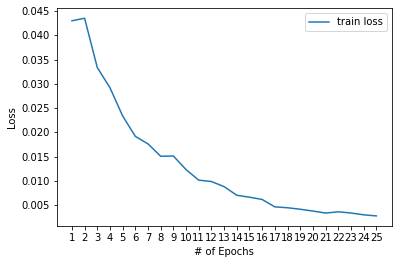

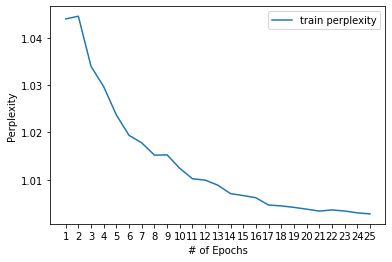

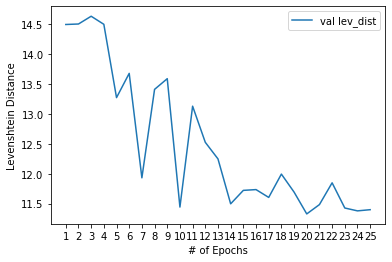

In [ ]:
# TODO: Define your model and put it on the device here
# ...


train_losses = []
train_perplexities = []
val_lev = []

for epoch in range(epoch_start, epochs+epoch_start):
    # schedule teacher_forcing_rate

    batch_bar_train = tqdm(total=len(train_loader), dynamic_ncols=True, leave=False, position=0, desc=f"Train Epoch {epoch}/{epochs}:")
    train_loss, train_perplexity, train_log = train(model, train_loader, criterion, optimizer, teacher_forcing_rate, batch_bar_train)
    train_losses.append(train_loss)
    train_perplexities.append(train_perplexity)
    save_log(train_log, drive_checkpoint, model_id)

    batch_bar_val = tqdm(total=len(val_loader), dynamic_ncols=True, leave=False, position=0, desc=f"Val Epoch {epoch}:")
    val_lev_dist, val_log = val(model, val_loader, criterion, batch_bar_val)
    val_lev.append(val_lev_dist)
    save_log(val_log, drive_checkpoint, model_id)
    
    # if epoch >= structure['learning_rate_patience']:
    #     scheduler.step(val_lev_dist)

    # schedule after lower than low cutoff
    scheduler.step(val_lev_dist)
    if start_tf_schedule or val_lev_dist <= structure['lev_dist_patience']:
        start_tf_schedule = True
        teacher_forcing_rate = tf_scheduler.step(val_lev_dist)
    
    if resume_from_prev and val_lev_dist <= 10:
        if change_dropout_flag:
            change_dropout_flag = False
            change_dropout(model, 0.4, LockedDropout)

    stats = {
        "epoch": epoch,
        "lr": float(optimizer.param_groups[0]['lr']),
        "train_loss": train_loss,
        "val_lev_dist": val_lev_dist, 
    }
    model_saver.save(StoredModel(model, optimizer, scheduler, criterion), stats, val_lev_dist)

# plot the loss curve
plt.plot(range(1, epochs+1), train_losses, label = "train loss")
# plt.plot(range(1, epochs+1), val_losses, label = "val loss")
plt.legend()
plt.xticks(range(1, epochs+1))
plt.xlabel("# of Epochs")
plt.ylabel("Loss")
plt.savefig(f"{checkpoints}/{model_id}/loss_curves.png")
plt.show()

# plot the perplexity curve
plt.plot(range(1, epochs+1), train_perplexities, label = "train perplexity")
# plt.plot(range(1, epochs+1), val_perplexities, label = "val perplexity")
plt.legend()
plt.xticks(range(1, epochs+1))
plt.xlabel("# of Epochs")
plt.ylabel("Perplexity")
plt.savefig(f"{checkpoints}/{model_id}/perplexity_curves.png")
plt.show()

# plot the levenshtein distance curve
plt.plot(range(1, epochs+1), val_lev, label = "val lev_dist")
plt.legend()
plt.xticks(range(1, epochs+1))
plt.xlabel("# of Epochs")
plt.ylabel("Levenshtein Distance")
plt.savefig(f"{checkpoints}/{model_id}/lev_dist_curves.png")
plt.show()


In [ ]:
print(f"The best epoch is: {model_saver.best_epoch}")
with open(f"{drive_checkpoint}/{model_id}/log.txt", mode='a') as f:
    f.write(f"The best epoch is: {model_saver.best_epoch}\n")

The best epoch is: 45


# Save model checkpoints to the Drive

In [ ]:
for file in os.listdir(f"{checkpoints}/{model_id}"):
    src = f"{checkpoints}/{model_id}/" + file
    dest = f"{drive_checkpoint}/{model_id}/" + file
    shutil.copy(src, dest)

# Inference and Submit to Kaggle

In [ ]:
def inference(model, data_loader, mode='test'):
    res = []
    batch_bar = tqdm(total=len(data_loader), dynamic_ncols=True, position=0, leave=False, desc=mode)

    for i, data in enumerate(data_loader):
        x, lx = data
        x, lx = x.to(DEVICE), lx.to(DEVICE)

        with torch.no_grad():
            predictions, _ = model(x, lx, mode='val')

            # Greedy Approach
            pred_transcripts = transform_index_to_letter(predictions.argmax(-1).detach().cpu().numpy(), letter2index['<eos>'])
            res.extend(pred_transcripts)

        batch_bar.update()
    batch_bar.close()

    return res

In [ ]:
torch.cuda.empty_cache()
_, model, _, _, _ = load_model(model_id=model_id, checkpoints=checkpoints, device=DEVICE, specific_epoch=model_saver.best_epoch)
res = inference(model, test_loader)

resuming from last_checkpoint epoch_45


In [ ]:
with open("submission.csv", "w+") as f:
    f.write("id,predictions\n")
    for i in range(len(test_data)):
        f.write(f"{str(i)},{res[i]}\n")

In [ ]:
!kaggle competitions submit -c 11-785-s22-hw4p2-slack -f submission.csv -m "model_5_r1"

100% 295k/295k [00:00<00:00, 1.49MB/s]
Successfully submitted to Attention-Based Speech Recognition (Slack)

In [ ]:
'''
Debugging suggestions from Eason, a TA from previous semesters:

(1) Decrease your batch_size to 2 and print out the value and shape of all intermediate variables to check if they satisfy the expectation
(2) Be super careful about the LR, don't make it too high. Too large LR would lead to divergence and your attention plot will never make sense
(3) Make sure you have correctly handled the situation for time_step = 0 when teacher forcing

(1) is super important and is the most efficient way for debugging. 
'''
'''
Tips for passing A from B (from easy to hard):
** You need to implement all of these yourself without utilizing any library **
(1) Increase model capacity. E.g. increase num_layer of lstm
(2) LR and Teacher Forcing are also very important, you can tune them or their scheduler as well. Do NOT change lr or tf during the warm-up stage!
(3) Weight tying
(4) Locked Dropout - insert between the plstm layers
(5) Pre-training decoder or train an LM to help make predictions
(5) Pre-training decoder to speed up the convergence: 
    disable your encoder and only train the decoder like train a language model
(6) Better weight initialization technique
(7) Batch Norm between plstm. You definitely can try other positions as well
(8) Data Augmentation. Time-masking, frequency masking
(9) Weight smoothing (avg the last few epoch's weight)
(10) You can try CNN + Maxpooling (Avg). Some students replace the entire plstm blocks with it and some just combine them together.
(11) Beam Search
'''

"\nTips for passing A from B (from easy to hard):\n** You need to implement all of these yourself without utilizing any library **\n(1) Increase model capacity. E.g. increase num_layer of lstm\n(2) LR and Teacher Forcing are also very important, you can tune them or their scheduler as well. Do NOT change lr or tf during the warm-up stage!\n(3) Weight tying\n(4) Locked Dropout - insert between the plstm layers\n(5) Pre-training decoder or train an LM to help make predictions\n(5) Pre-training decoder to speed up the convergence: \n    disable your encoder and only train the decoder like train a language model\n(6) Better weight initialization technique\n(7) Batch Norm between plstm. You definitely can try other positions as well\n(8) Data Augmentation. Time-masking, frequency masking\n(9) Weight smoothing (avg the last few epoch's weight)\n(10) You can try CNN + Maxpooling (Avg). Some students replace the entire plstm blocks with it and some just combine them together.\n(11) Beam Search